In [14]:
import os 
import numpy as np
import pandas as pd
import rasterio
import os
import pystac
import pystac_client
import planetary_computer
import geopandas as gpd
from rich.table import Table
import rioxarray
import requests
from shapely.geometry import Polygon, shape, box
from shapely.ops import transform
from rich.table import Table
from rioxarray.merge import merge_arrays
from rasterio.plot import plotting_extent
from rasterstats import zonal_stats
from xrspatial.zonal import stats as zonal_stats
from geocube.api.core import make_geocube
import xarray
from azureml.core import Workspace, Dataset
import multiprocessing
from multiprocessing import Pool
from functools import partial
from rasterio.plot import show
from rioxarray.merge import merge_arrays


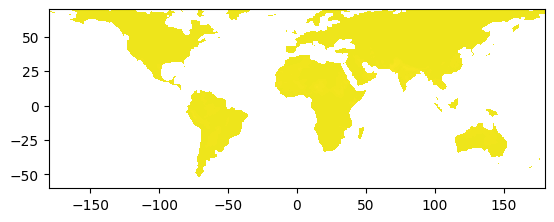

<Axes: >

In [15]:
directory = os.getcwd() + '/data'   # set directory
heat_data = rasterio.open('global_mean_wbgt_30.tif')    # load heat data       
show(heat_data) #make a plot of heat

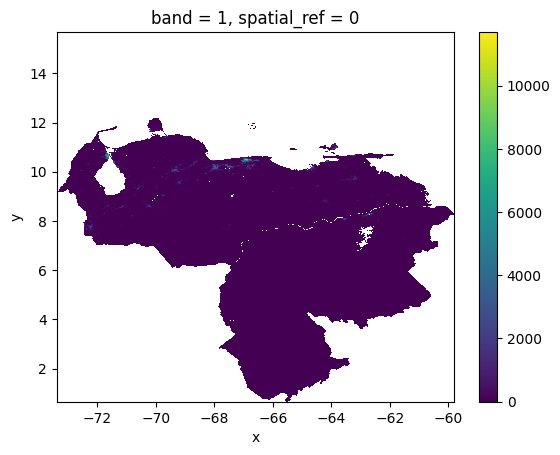

In [23]:
# Read pop data in
countryCode = 'ven'
fileName = '_ppp_2020_1km_Aggregated_UNadj.tif'

filePath = directory + '/' + countryCode + fileName

country_pop = rioxarray.open_rasterio(filePath, masked=True)
country_pop.squeeze().plot.imshow()

In [24]:
outFileName = directory + '/' + countryCode + '_heat_flood_extract.csv'
outFileName

'/mnt/batch/tasks/shared/LS_root/mounts/clusters/p18q1264/code/Users/p18q126/data/ven_heat_flood_extract.csv'

In [25]:
# Find bbox
country_box = country_pop.rio.bounds()
print(country_box)

(-73.38458304795367, 0.6579168666905797, -59.809583102253676, 15.674583473290582)


In [26]:
# turn to points
country_pop.name = "pop_data"
country_pop_df = country_pop.squeeze().to_dataframe().reset_index()
geometry = gpd.points_from_xy(country_pop_df.x, country_pop_df.y)
country_pop_gdf = gpd.GeoDataFrame(country_pop_df, crs=country_pop.rio.crs, geometry=geometry)
country_pop_gdf

,y,x,band,spatial_ref,pop_data,geometry
0,15.670417,-73.380416,1,0,NaN,POINT (-73.38042 15.67042)
1,15.670417,-73.372083,1,0,NaN,POINT (-73.37208 15.67042)
2,15.670417,-73.363750,1,0,NaN,POINT (-73.36375 15.67042)
3,15.670417,-73.355416,1,0,NaN,POINT (-73.35542 15.67042)
4,15.670417,-73.347083,1,0,NaN,POINT (-73.34708 15.67042)
...,...,...,...,...,...,...
2935453,0.662084,-59.847083,1,0,NaN,POINT (-59.84708 0.66208)
2935454,0.662084,-59.838750,1,0,NaN,POINT (-59.83875 0.66208)
2935455,0.662084,-59.830416,1,0,NaN,POINT (-59.83042 0.66208)
2935456,0.662084,-59.822083,1,0,NaN,POINT (-59.82208 0.66208)


In [27]:
# remove pixels w/ no people
# Replace zeros with NaN
country_pop_gdf['pop_data'].replace(0, np.nan, inplace=True)

# Drop NaN values
country_pop_gdf.dropna(subset=['pop_data'], inplace=True)

country_pop_gdf

,y,x,band,spatial_ref,pop_data,geometry
1171,15.670417,-63.622083,1,0,1.636641,POINT (-63.62208 15.67042)
1172,15.670417,-63.613750,1,0,0.745882,POINT (-63.61375 15.67042)
2800,15.662083,-63.622083,1,0,0.152757,POINT (-63.62208 15.66208)
2801,15.662083,-63.613750,1,0,0.076354,POINT (-63.61375 15.66208)
647010,12.362083,-70.905416,1,0,0.351270,POINT (-70.90542 12.36208)
...,...,...,...,...,...,...
2933139,0.670417,-65.555416,1,0,0.232870,POINT (-65.55542 0.67042)
2933140,0.670417,-65.547083,1,0,0.201447,POINT (-65.54708 0.67042)
2933141,0.670417,-65.538750,1,0,0.152985,POINT (-65.53875 0.67042)
2934769,0.662084,-65.547083,1,0,0.148652,POINT (-65.54708 0.66208)


In [28]:
# extract heat
heat_data = rasterio.open('global_mean_wbgt_30.tif', masked=True)

country_pop_gdf.index = range(len(country_pop_gdf))
coords = [(x,y) for x, y in zip(country_pop_gdf.x, country_pop_gdf.y)]

country_pop_gdf['heat_value'] = [x[0] for x in heat_data.sample(coords)]
country_pop_gdf

,y,x,band,spatial_ref,pop_data,geometry,heat_value
0,15.670417,-63.622083,1,0,1.636641,POINT (-63.62208 15.67042),-9999.0
1,15.670417,-63.613750,1,0,0.745882,POINT (-63.61375 15.67042),-9999.0
2,15.662083,-63.622083,1,0,0.152757,POINT (-63.62208 15.66208),-9999.0
3,15.662083,-63.613750,1,0,0.076354,POINT (-63.61375 15.66208),-9999.0
4,12.362083,-70.905416,1,0,0.351270,POINT (-70.90542 12.36208),-9999.0
...,...,...,...,...,...,...,...
1074347,0.670417,-65.555416,1,0,0.232870,POINT (-65.55542 0.67042),0.0
1074348,0.670417,-65.547083,1,0,0.201447,POINT (-65.54708 0.67042),0.0
1074349,0.670417,-65.538750,1,0,0.152985,POINT (-65.53875 0.67042),0.0
1074350,0.662084,-65.547083,1,0,0.148652,POINT (-65.54708 0.66208),0.0


In [29]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# create AOI using a bounding box for Bangladesh
AOI = shape({
  "coordinates": [
    [
      [country_box[0],
        country_box[1]],

      [country_box[0],
        country_box[3]],

      [country_box[2],
        country_box[1]],
        
      [country_box[2],
        country_box[3]]
    ]
  ],
  "type": "Polygon"
}).envelope

# execute a STAC API query using the bounding box for our selected area
jrc = catalog.search(collections=["jrc-gsw"], intersects=AOI)
items = jrc.item_collection()
print(f"Returned {len(items)} Items")

Returned 6 Items


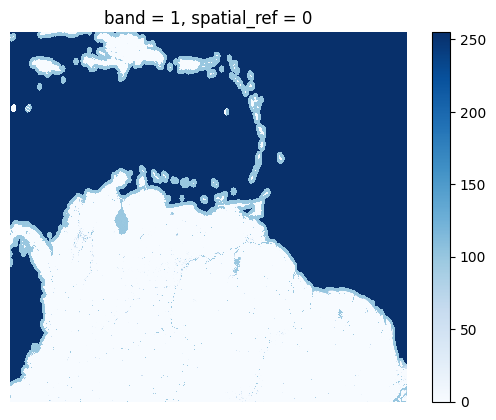

In [30]:
n = len(items)
doubles = dict()

for i in range(0, n):
    item = items[i]
    
    doubles[i] = rioxarray.open_rasterio(item.assets["occurrence"].href, overview_level=4).squeeze()

flood_data = merge_arrays(dataarrays = list(doubles.values()), crs = "EPSG:4326")
img = flood_data.plot(cmap="Blues", add_colorbar=True)
img.axes.set_axis_off();

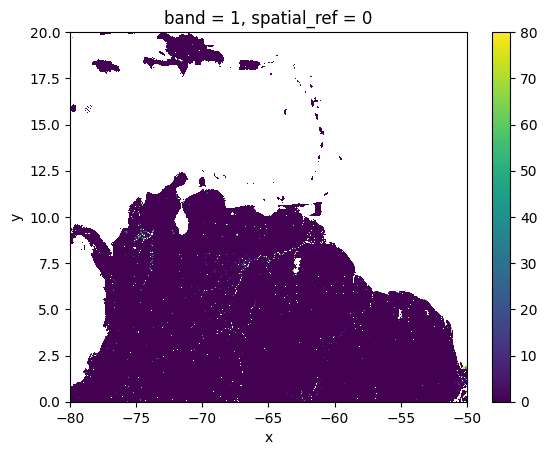

In [31]:
# Remove values of 100, and values of 255)
# Replace values over 80 with NaN
flood_data = flood_data.where(flood_data <= 80, np.nan)

#flood_data = flood_data.where(flood_data != 100)
#flood_data = flood_data.where(flood_data != 255)

# update nodata value to show the data has been masked
flood_data.rio.write_nodata(flood_data.rio.nodata, encoded=True, inplace=True)

# Plot data with the values of 100 and 255 removed 
flood_data.squeeze().plot.imshow()

In [32]:
# Create a buffered polygon layer from your plot location points
country_pop_gdf_buff = country_pop_gdf.copy()

# Buffer each point using a 1km meter circle radius
# and replace the point geometry with the new buffered geometry
country_pop_gdf_buff["geometry"] = country_pop_gdf.geometry.buffer(0.008)
country_pop_gdf_buff["id"] = country_pop_gdf_buff.index + 1

/tmp/ipykernel_5012/713000173.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  country_pop_gdf_buff["geometry"] = country_pop_gdf.geometry.buffer(0.008)


In [33]:
out_grid = make_geocube(
    vector_data= country_pop_gdf_buff,
    measurements=["id"],
    like=flood_data, # ensure the data are on the same grid
)

# merge the two together
out_grid["flood_data"] = (flood_data.dims, flood_data.values, flood_data.attrs, flood_data.encoding)

grouped_flood_data = out_grid.drop("spatial_ref").groupby(out_grid.id)

grid_mean = grouped_flood_data.mean(skipna=True).rename({"flood_data": "flood_value"})

zonal_stats = xarray.merge([grid_mean]).to_dataframe()

# merge back in w geopandas df from before
country_final_data = country_pop_gdf_buff.merge(zonal_stats, on='id')
country_final_data = pd.DataFrame(country_final_data.drop(columns=['geometry', 'band', 'spatial_ref']))

country_final_data["country_iso"] = countryCode
country_final_data

,y,x,pop_data,heat_value,id,flood_value,country_iso
0,15.670417,-63.622083,1.636641,-9999.0,1,NaN,ven
1,15.670417,-63.613750,0.745882,-9999.0,2,NaN,ven
2,15.662083,-63.622083,0.152757,-9999.0,3,NaN,ven
3,15.662083,-63.613750,0.076354,-9999.0,4,NaN,ven
4,12.362083,-70.905416,0.351270,-9999.0,5,NaN,ven
...,...,...,...,...,...,...,...
1074347,0.670417,-65.555416,0.232870,0.0,1074348,0.0,ven
1074348,0.670417,-65.547083,0.201447,0.0,1074349,0.0,ven
1074349,0.670417,-65.538750,0.152985,0.0,1074350,0.0,ven
1074350,0.662084,-65.547083,0.148652,0.0,1074351,0.0,ven


In [34]:
countryCode = "ven"
country_final_data["country_iso"] = countryCode
country_final_data['flood_days'] = country_final_data['flood_value'] / 100 * 365

# make new columns numeric
country_final_data['flood_days'] = pd.to_numeric(country_final_data['flood_days'])
country_final_data['flood_value'] = pd.to_numeric(country_final_data['flood_value'])

country_final_data

,y,x,pop_data,heat_value,id,flood_value,country_iso,flood_days
0,15.670417,-63.622083,1.636641,-9999.0,1,NaN,ven,NaN
1,15.670417,-63.613750,0.745882,-9999.0,2,NaN,ven,NaN
2,15.662083,-63.622083,0.152757,-9999.0,3,NaN,ven,NaN
3,15.662083,-63.613750,0.076354,-9999.0,4,NaN,ven,NaN
4,12.362083,-70.905416,0.351270,-9999.0,5,NaN,ven,NaN
...,...,...,...,...,...,...,...,...
1074347,0.670417,-65.555416,0.232870,0.0,1074348,0.0,ven,0.0
1074348,0.670417,-65.547083,0.201447,0.0,1074349,0.0,ven,0.0
1074349,0.670417,-65.538750,0.152985,0.0,1074350,0.0,ven,0.0
1074350,0.662084,-65.547083,0.148652,0.0,1074351,0.0,ven,0.0


In [35]:
country_final_data.to_csv(outFileName, index = False)